## Meta data

In [3]:
import netCDF4 as nc4
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import tqdm
import scipy.ndimage as nd
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
import matplotlib.colors as col #ListedColormap
import matplotlib.path as mpp
import h5py  # For NEW Matlab files (AMEDA)
import scipy.io as sio # For OLD Matlab files
from matplotlib import rcParams
rcParams['pcolor.shading']='auto'

expname='qwa116'  #      <============ Change run name here !

path_dir='/home6/datawork/abarboni/CROCO/TEMP_1km/SAVE_HIS-AVG/'
his_name=path_dir+expname+'_his.nc'
avg_name=path_dir+expname+'_avg.nc'
gridname=path_dir+'grd_lat385_1km.nc'

path_ameda='/home6/datawork/abarboni/CROCO/RESULT/'+expname.upper()+'/'

timestep=2 ## time in day between time step of netcdf _avg file
rg=1 # side padding to reduce data size
depth_m=30  #extracted max depth  (typically choose > 25)
Xmax=100 # (half) window size in km
#### NAVG should be >10 (i.e 5 times per day) to properly investigate NIW
Navg=2   ### padding between _his and _avg files : timestep(avg) = Navg*timestep(his)
Nt=1 # timestep selection (keep it to 1)

str_title='Run '+expname.upper()+' - AE 1km ERA5 1-hour '
str_title

'Run QWA116 - AE 1km ERA5 1-hour '

## Loading data

In [4]:
### Grid   ### MAKE SURE IT IS THE GOOD ONE !
f=nc4.Dataset(gridname)   
x_rho=f['x_rho'][rg:-rg,rg:-rg]/1000 ; y_rho=f['y_rho'][rg:-rg,rg:-rg]/1000
xi_rho=x_rho[0,:]
xmid=int(f.dimensions['xi_rho'].size/2)
f.close()
x_psi=(x_rho[1:,1:]+x_rho[1:,:-1]+x_rho[:-1,1:]+x_rho[:-1,:-1])/4
y_psi=(y_rho[1:,1:]+y_rho[1:,:-1]+y_rho[:-1,1:]+y_rho[:-1,:-1])/4
dx=np.diff(x_rho, axis=1)[0,0]*1000 ; dy=np.diff(y_rho, axis=0)[0,0]*1000 # in meters
x_div=x_rho[1:-1,1:-1] ; y_div=y_rho[1:-1,1:-1]
xi_psi=x_psi[0]

In [6]:
### AVG Data
f=nc4.Dataset(avg_name) #filename)
srho=f['s_rho'][:]
H0=f['h'][0,0] ; hc=f['hc'][:]
### Streching coeff
Csr=f['Cs_r'][:] ; sw=f['s_w'][:] ; Csw=f['Cs_w'][:] 
#######z0=hc*srho+(H0-hc)*Csr ## OLD S COORD
z0=H0*(hc*srho+H0*Csr)/(hc+H0) ## NEW S COORD
z_w= H0*(hc*sw+H0*Csw)/(hc+H0) 
idmax=np.argmin(np.abs(z0+depth_m))
time_a=f['time'][::Nt]/24/3600 #time in days
W_a=f['w'][:,idmax:,rg:-rg,rg:-rg] # *100*3600 if UNITS = cm/h, m/s otherwise

qtot=f['shflux'][:,rg:-rg,rg:-rg]       ### FLUXES 
ustr=f['sustr'][:,rg:-rg,rg:-rg] ; vstr=f['svstr'][:,rg:-rg,rg:-rg] # in N/m^2
f.close()

In [9]:
 
zvert=z0[idmax:] ; z_dzt=z_w[idmax:]
Nvert=len(zvert) ; Nx=len(xi_rho) ; Ny=len(xi_rho) ; Ns=len(time_a) #numb timesteps

In [10]:
### HIS file  = BIG DATA
f=nc4.Dataset(his_name)  
time_h=f['time'][:]/24/3600#time in days
SST=f['temp'][int(Navg/2)::Navg,-1,rg:-rg,rg:-rg]     ### Warning : SST is at same time step than _avg, not W_h
#temp_h=f['temp'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
W_h=f['w'][:,idmax:,rg:-rg,rg:-rg] # *100*3600 if UNITS = cm/h, m/s otherwise

#AKv=f['AKt'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
#Eps=f['gls'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]  ### Warning : dissipation rate epsilon is under 'gls' variable depending on GLS_MIXING choices
f.close()
Nh=len(time_h)

### Checking Heat fluxes

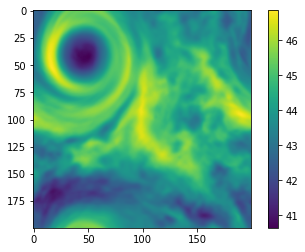

In [11]:
plt.imshow(qtot[-10]) ; plt.colorbar()
Qmean=np.mean(qtot, axis=(1,2))
Umean=np.mean(ustr,axis=(1,2)) ; Vmean=np.mean(vstr,axis=(1,2)) ; Wmean=np.sqrt(Umean**2+Vmean**2)
Wspeed=np.sqrt(Wmean/0.0016/1.2)

## Computing W' (in summer only)

In [18]:
t_bd_first=[115,170] ; t_bd_second=[295,350]  ## timestep interval for first and second summer

idt=np.where((time_h>=t_bd_second[0]*2) & (time_h<t_bd_second[1]*2))[0]  ## Choosing 2nd summer
W_ph=W_h[idt]   ### Quick Fix
time_ph=time_h[idt]
Nid=len(time_h[idt]) 
Nid

110

In [17]:
ida=np.where((time_a>t_bd_second[0]*2) & (time_a<t_bd_second[1]*2))[0]
Na=len(ida)
W_pa=W_a[ida]
time_pa=time_a[ida]
Na  #### Check here that Nid = Na*Navg

55

In [14]:
W_p=np.zeros(np.shape(W_ph))       ## w'(t,z,x,y)
time_p=np.zeros(Nid)
for t in tqdm(range(Na)):
    for i in range(Navg):
        W_p[t*Navg+i]=W_ph[t*Navg+i]-W_pa[t]
        time_p[t*Navg+i]=time_ph[t*Navg+i]-time_pa[t]


0it [00:00, ?it/s]


## Loading AMEDA result (with HDF5 refs)

In [35]:
## Param_eddy_tracking
params_dict = sio.loadmat(path_ameda+'param_eddy_tracking.mat')
deg=int(params_dict['deg']) ; resol=int(params_dict['resol'])

## Grid
grid_dict = sio.loadmat(path_ameda+'gridvel_deg'+str(deg)+'_resol'+str(resol)+'.mat')
x_am=grid_dict['x'] ; y_am=grid_dict['y']
## Tracks
D = h5py.File(path_ameda+'eddy_tracks.mat','r')  ## Or tracks2.mat ??
tracks=D['tracks']
Ned=tracks['step'].shape[0]

print('Number of timesteps :'+str(int(params_dict['stepF'])) ) ## Checking time and shape
print('Number of eddies :'+str(Ned))

Number of timesteps :388
Number of eddies :229


In [36]:
StepEddy=np.zeros((Ned, len(time)))  ## Presence matrix
Polarity=np.zeros(Ned)
for i in range(Ned):
    StepEddy[i,D[tracks['step'][i,0]][0].astype(int)-1]=1  
    ### "-1" is important because steps are counted in Matlab, in Python first index starts at 0
    Polarity[i]=np.mean(D[tracks['type'][i,0]][0].astype(int))
Color=np.zeros(Ned).astype(str)
Color[Polarity==-1]='b' ; Color[Polarity==1]='r'

Text(0.5, 1.0, 'Eddy occurence matrix')

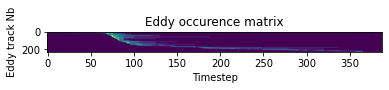

In [37]:
plt.imshow(StepEddy, aspect=1/10) ; plt.xlabel('Timestep') ; plt.ylabel('Eddy track Nb')
plt.title('Eddy occurence matrix')

## Selecting anticyclone main track (touchy)

This step is touchy as the main anticyclone tracked can be considered simply as the one having the longest lifetime.
However AMEDA does not understand periodic borders (in the considered version). Then if the anticyclone crosses the domain borders, you have to manually change track by indicating with the variable `DayEddy` the timestep range for each partial track.

Check later with SST plots that the considered main track is always in the domain (by showing also track numbers)

### Automatic version (in case no border crossing)

In [38]:
MainEddy=np.where((np.sum(StepEddy, axis=1)>200) & (Polarity==-1))[0]
print( 'Eddy index living more than x timesteps :')
[ x for x in MainEddy.astype(str)]  ### there should be only one track living more than 200 timesteps

Eddy index living more than x timesteps :


['0']

Text(0, 0.5, 'Days')

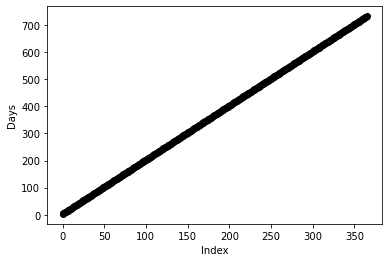

In [39]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for h in MainEddy:  ## MainEddy should contain only the eddy to be tracked !!
    Rmax+=list(D[tracks['rmax1'][h,0]][0])
    Vmax+=list(D[tracks['velmax1'][h,0]][0])
    timeeddy+=list(D[tracks['step'][h,0]][0]*timestep+time[0])
    X1+=list(D[tracks['x1'][h,0]][0]) ; Y1+=list(D[tracks['y1'][h,0]][0])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

### Manual tracking (in case border crossing)

In [37]:
#### MANUAL SELECTION

#MainEddy=np.array([0,44]) ### QWA115
#DayEddy=np.array([[0,420],[422,720]])

MainEddy=np.array([0,158]) ### QWA204    <=== indicate the indivual tracks
DayEddy=np.array([[0,220],[221,360]])*timestep#  <== indicate the valid step range for each track   

In [ ]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for ide,h in enumerate(MainEddy):
    steps=D[tracks['step'][h,0]][0]*timestep+time[0]  ## Adding time_h[0] in case of restart\
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]

    Rmax+=list(D[tracks['rmax1'][h,0]][0][ided])
    Vmax+=list(D[tracks['velmax1'][h,0]][0][ided])
    timeeddy+=list(D[tracks['step'][h,0]][0][ided]*timestep+time[0])
    X1+=list(D[tracks['x1'][h,0]][0][ided]) ; Y1+=list(D[tracks['y1'][h,0]][0][ided])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

##  SST Scaling

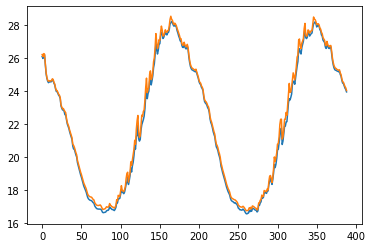

In [42]:
SSTmax_h=np.max(SST,axis=(1,2))   ### HIS version
SSTmin_h=np.min(SST,axis=(1,2))
SSTmean_h=np.mean(SST,axis=(1,2)) #nd.gaussian_filter1d(np.mean(temp_h[:,-1],axis=(1,2)),sigma=2)
plt.plot(SSTmin_h) ; plt.plot(SSTmean_h)

In [43]:
cust=cm.Spectral_r ; Ncycl=0
my_cmap = cust(np.arange(cust.N))
my_cmap[:,-1] = 1-0.9*(np.sin(np.linspace(0, Ncycl*np.pi, cust.N))**10) #np.linspace(0, 1, cust.N)
my_cmap = col.ListedColormap(my_cmap)

## SST maps with AMEDA

100%|██████████| 6/6 [00:00<00:00, 27.43it/s]


Text(0.5, 0.95, 'Run QWA116 - AE 1km ERA5 1-hour  - t= 601 days')

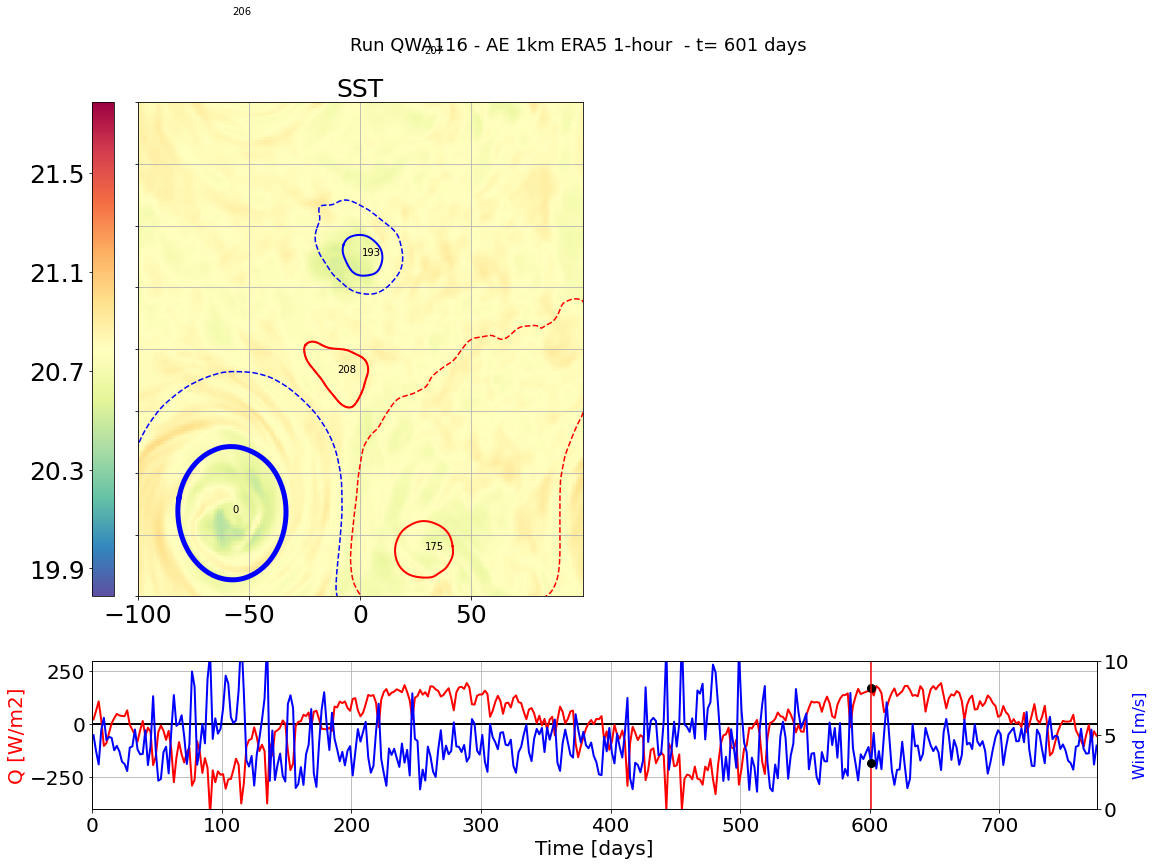

In [44]:
### Just 1 timstep
t=300  # chosen timestep
plot_number=True ;     ### To plot track number and be sure which one is plotted
dTmax=1                ### colorbar range

SSTticks=np.arange(SSTmean_h[t]-2.5-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+2-(SSTmean_h[t]-dTmax)%1,0.4)

plt.figure(0, figsize=(18,13))
gs = GridSpec(2, 4, width_ratios=[1/20,1,1,1/20], height_ratios=[10,3], wspace=0.1, hspace=0.2)

### SST
plt.subplot(gs[0,1])
plt.pcolormesh(xi_rho,xi_rho,SST[t,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=cm.Spectral_r)

### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    if plot_number:
        plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))
    
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=25)  
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() #; plt.ylabel('Distance [km]', size=18)
plt.xticks(np.arange(-100,100,50))
plt.tick_params(labelleft=False, labelsize=25)
CB1=plt.colorbar(cax=plt.subplot(gs[0,0]))#, orientation='horizontal')
CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=25)

ax1=plt.subplot(gs[1,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
plt.tick_params(labelsize=20)
tf=np.argmin(np.abs(time-time[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=20, color='r')
plt.ylim([-400,300])
plt.xlabel('Time [days]', size=20)

ax2=ax1.twinx()      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.tick_params(labelsize=20)
plt.ylabel('Wind [m/s]',size=16, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.95)


## Computing eddy masks

AMEDA contours are used to crop outside- and inside-eddy areas at each timesteps through masks => Masks are defined at time steps _avg

In [45]:
xlist=np.reshape(x_rho,len(x_rho)**2) ; ylist=np.reshape(y_rho,len(x_rho)**2)
#xpsilist=np.reshape(x_psi,len(x_psi)**2) ; ypsilist=np.reshape(y_psi,len(x_psi)**2)
pts=np.array([xlist,ylist]).T #; ptspsi=np.array([xpsilist,ypsilist]).T

In [46]:
MaskEnd=np.zeros((Ns, Nx,Nx))      ### mask in time_avg !
for t in tqdm(range(len(time))):
    ListPs=np.where(StepEddy[:,t])[0]
    ### Mask removing all eddies
    for i in range(len(ListPs)):
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]## Rmax or Rend : 'shapes1' or 'shapes3'
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho)) ; MaskEnd[t]+=Inside

100%|██████████| 388/388 [01:08<00:00,  5.64it/s]


In [47]:
MaskMain=np.zeros((Ns, Nx, Nx)) 
if not 'DayEddy' in locals(): #### in the case no border crossing, DayEddy is not defined
    DayEddy=np.array([[0,time_h[-1]]])    

for ide,h in enumerate(tqdm(MainEddy)):  # iteration on track number
    steps=D[tracks['step'][h,0]][0]*timestep+time_h[0]
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]
    for idbis in ided :
        Contour=D[D[tracks['shapes1'][h,0]][0][idbis]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho)) 
        MaskMain[int((steps[idbis]-time_h[0])/timestep)-1]+=Inside

100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Text(0.5, 1.0, 'Masking all eddies')

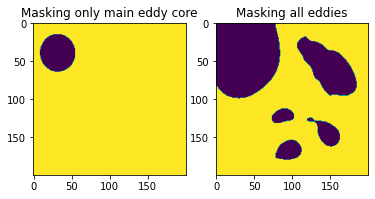

In [79]:
t=200  ## Check for 1 timestep
plt.subplot(121) ; plt.imshow(~MaskMain[t]) ; plt.title('Masking only main eddy core')
plt.subplot(122) ; plt.imshow(~MaskEnd[t]) ; plt.title('Masking all eddies')

100%|██████████| 55/55 [00:00<00:00, 3731.10it/s]


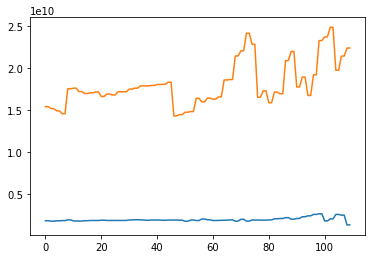

In [53]:
AreaMain=np.zeros(len(time_ph))  ## Area in m2 over Nid time vector
AreaOut=np.zeros(len(time_ph))
for t in tqdm(range(len(time_pa))):
    for i in range(Navg):
        AreaMain[t*Navg+i]=np.sum(MaskMain[t])*dx*dx
        AreaOut[t*Navg+i]=np.sum(~MaskEnd[t])*dx*dx
plt.plot(AreaMain) ; plt.plot(AreaOut)  ### Check both areas are roughly constant

### Extracting vertical speed, following eddy

In [52]:
### Data from HIS
WEddy_p=np.copy(W_p) ; WOut_p=np.copy(W_p) #starts at t_bd_ter[0]

for t in tqdm(range(len(time_pa))):
    if np.any(MaskMain[t]):
        for z in range(Nvert):
            for k in range(Navg):  ### Data from HIS
                WEddy_p[t*Navg+k,z][~MaskMain[t]]=0
    else:
        WEddy_p[t]=0
#### MaskEnd
    if np.any(MaskEnd[t]):
        for z in range(Nvert):
            for k in range(Navg):  ### Data from HIS
                WOut_p[t*Navg+k,z][MaskEnd[t]]=0
    else:
        WOut_p[t]=0

100%|██████████| 55/55 [00:00<00:00, 495.23it/s]


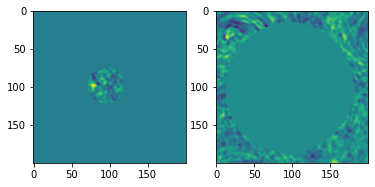

In [56]:
plt.subplot(121)   ### Test
plt.imshow(WEddy_p[10,5])
plt.subplot(122)
plt.imshow(WOut_p[10,5])

# Spectral Analysis

## Multidimensional FFT : 2D Test

In [68]:
depth=20        #     <====== Chosen depth for analysis 
idz=np.argmin(np.abs(zvert+depth))
W_omk=np.fft.fftn(W_p[:,idz,100,:],axes=(0,1))  ### Test WITHOUT EDDY CROPPING
k_freqR=np.fft.rfftfreq(Nx,dx/1000)  ## real wavenumber vector!
omega=np.fft.fftfreq(Nid,2/Navg)  ## in  day-1  !
omegaR=omega[:int(Nid/2)]

In [63]:
W_ok_R=np.zeros((len(omegaR),len(k_freqR)))
for j in tqdm(range(len(k_freqR))):
                #omegaR)):
    if j==0: ### for zero freq
        for i in range(1,len(omegaR)): 
            W_ok_R[i,j]=1/2*(np.abs(W_omk[i,j]**2)+np.abs(W_omk[Nid-i,j]**2))
    else:
        for i in range(1,len(omegaR)): 
            W_ok_R[i,j]=1/4*(np.abs(W_omk[i,j]**2)+np.abs(W_omk[Nid-i,j]**2)+np.abs(W_omk[i,Nx-j]**2)+np.abs(W_omk[Nid-i,Nx-j]**2))
            

100%|██████████| 101/101 [00:00<00:00, 1522.72it/s]


Text(0, 0.5, 'Energy density [m^2.s^-2/cpkm/cpd]')

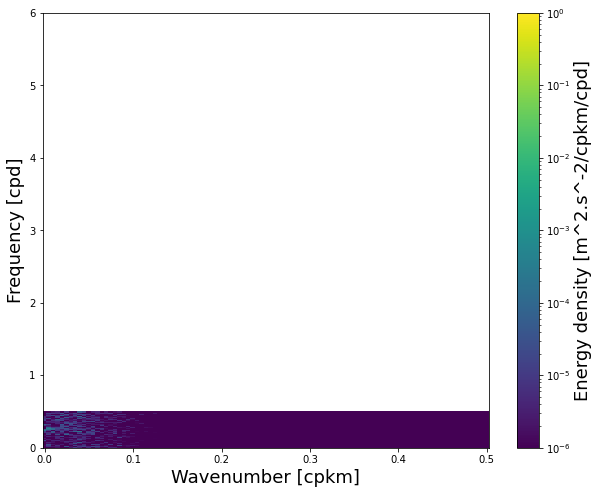

In [64]:
plt.figure(0, figsize=(10,8))
plt.pcolor(k_freqR,omegaR,np.abs(W_ok_R[:,:101]**2),norm=col.LogNorm(vmin=1e-6, vmax=1e0))
plt.plot([0,0.5],[f,f],'--w',lw=2)
plt.ylim([0,6])
plt.xlabel('Wavenumber [cpkm]',size=18)
plt.ylabel('Frequency [cpd]',size=18)
CB=plt.colorbar()
CB.ax.set_ylabel('Energy density [m^2.s^-2/cpkm/cpd]',size=18)
plt.title('2D (omega,k) test at a given level')

## Multidimensional FFT : 3D case for a given level (omega, k,l)

In [66]:
k_1d=np.fft.fftfreq(Nx,dx/1000)  ## x and y wavenumbers in cpkm
l_1d=np.fft.fftfreq(Nx,dx/1000)  ## x and y wavenumbers in cpkm
k_freqR=np.fft.rfftfreq(Nx,dx/1000)
DT=time_ph[-1]-time_ph[0]

omega=np.fft.fftfreq(Nid,2/Navg)  ## in  day-1  !
omegaR=omega[:int(Nid/2)]

dk=np.diff(k_1d)[0]
domega=np.diff(omega)[0]

k_2d,l_2d=np.meshgrid(k_1d,l_1d)
Kh=np.sqrt(k_2d**2+l_2d**2)    ## 2D wavenb matrix
dk=np.diff(k_1d)[0]  ## Spectral resolution => La prendre variable pour tenir compte pixelisation cercle ?

In [67]:
W2_okl=np.abs(np.fft.fftn(W_p[:,idz,:,:],axes=(0,1,2))**2)    ### Without eddy cropping
W2eddy_okl=np.abs(np.fft.fftn(WEddy_p[:,idz,:,:],axes=(0,1,2))**2)  ## Blanking outside eddy
W2out_okl=np.abs(np.fft.fftn(WOut_p[:,idz,:,:],axes=(0,1,2))**2)    ## Blanking inside eddy

#### Area normalisation for energy density

In [71]:
KEtot=np.sum(W_p[:,idz,:,:]**2)/Nx/dx/Nx/dx/Nid  ###  vertical energy density in m2/s2/m2 in real space (without eddy cropping)
KEtot   

1.9239432357709274e-14

In [70]:
KEeddy=np.nansum(np.nansum(WEddy_p[:,idz,:,:]**2,axis=(1,2))/AreaMain)/Nid
KEout=np.nansum(np.nansum(WOut_p[:,idz,:,:]**2,axis=(1,2))/AreaOut)/Nid
KEeddy, KEout ### Vertical energy density in m2/s2/m2 for inside / Outside-eddy

(2.4043721482342734e-14, 1.7785539957411694e-14)

In [72]:
### Checking Parseval : energy is the same in real and transformed space
np.sum(W2_okl/len(k_1d)/len(k_1d)/len(omega))/Nx/dx/Nx/dx/Nid ### vertical energy in m2/s2/m2 in Fourier space(without eddy cropping)

1.923943235770927e-14

### Isotropisation : integrating for common K=sqrt(k^2+l^2)

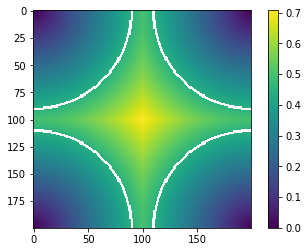

In [73]:
Kh_m=np.copy(Kh)  ### Checking wavenumber "circle" with constant |K|
i=90 ; k=k_freqR[i]
Kh_m[(Kh>k-dk/2) & (Kh<k+dk/2)]=np.nan
plt.imshow(Kh_m)  ; plt.colorbar()
#np.abs(W_omkl[20][(Kh>k-dk/2) & (Kh<k+dk/2)])

In [74]:
W2_oK=np.zeros((Nid,len(k_freqR)))
W2eddy_oK=np.zeros((Nid,len(k_freqR)))
W2out_oK=np.zeros((Nid,len(k_freqR)))

for j,k in enumerate(tqdm(k_freqR)):
    for i in range(Nid):
        W2_oK[i,j]=np.sum(W2_okl[i][(Kh>k-dk/2) & (Kh<k+dk/2)])
        W2eddy_oK[i,j]=np.sum(W2eddy_okl[i][(Kh>k-dk/2) & (Kh<k+dk/2)])
        W2out_oK[i,j]=np.sum(W2out_okl[i][(Kh>k-dk/2) & (Kh<k+dk/2)])

100%|██████████| 101/101 [00:02<00:00, 42.66it/s]


In [75]:
#### Summing positive / negative frequency
W2_ok_R=np.zeros((len(omegaR),len(k_freqR)))
W2eddy_ok_R=np.zeros((len(omegaR),len(k_freqR)))
W2out_ok_R=np.zeros((len(omegaR),len(k_freqR)))

for i in tqdm(range(len(omegaR))):
    if i==0: ### for zero freq
        W2_ok_R[i,:]=W2_oK[i,:]
        W2eddy_ok_R[i,:]=W2eddy_oK[i,:]
        W2out_ok_R[i,:]=W2out_oK[i,:]
    else:
        W2_ok_R[i,:]=0.5*(W2_oK[i,:]+W2_oK[Nid-i,:])
        W2eddy_ok_R[i,:]=0.5*(W2eddy_oK[i,:]+W2eddy_oK[Nid-i,:])
        W2out_ok_R[i,:]=W2out_oK[i,:]

100%|██████████| 55/55 [00:00<00:00, 76084.01it/s]


## Plots

In [21]:
f_coriolis=2*np.sin(np.pi/180*38.5) ## in day-1, change latitude if needed
zeta0=2*0.28*np.exp(1/1.6)/28e3
zeta0*86400/2/np.pi

feff=f_coriolis-zeta0*86400/2/np.pi/2  ## f_eff = f + zeta/2 # /2 cf  is important cf Danioux 2015
feff,f       ### Effective & Normal Coriolis freq

(0.9881270129874535, 1.245029273275239)

### Fourier over the total field

In [ ]:
plt.figure(0, figsize=(10,10))                      #### TOTAL Field
plt.pcolor(k_freqR,omegaR,W2_ok_R/len(k_1d)/len(k_1d)/len(omegaR)/dx/Nx/dx/Nx,norm=col.LogNorm(vmin=1e-18, vmax=1e-13))
plt.plot([0,1],[f,f],'--w',lw=3)
plt.xscale('log') ; plt.yscale('log')
CB=plt.colorbar()
CB.ax.set_ylabel('Surfacic Energy Density [m2/s2/cpkm/cpd/m2]', size=15)
plt.xlabel('Horizontal wavenumber [cpkm]',size=15)
plt.ylabel('Frequency [cpd]', size=15)
plt.tick_params(labelsize=15)
plt.xlim([k_freqR[1],0.3]);plt.ylim([omegaR[1],10])
plt.title('vert speed spectrum at z='+str(depth)+'m - dx=1km',size=17)

### Fourier Inside-eddy

In [ ]:
plt.figure(0, figsize=(10,10))                      #### Inside-Eddy
plt.pcolor(k_freqR,omegaR,W2eddy_ok_R/len(k_1d)/len(k_1d)/len(omegaR)/np.mean(AreaMain),norm=col.LogNorm(vmin=1e-18, vmax=1e-13))
plt.plot([0,1],[f,f],'--w',lw=3)
plt.xscale('log') ; plt.yscale('log')
CB=plt.colorbar()
CB.ax.set_ylabel('Surfacic Energy Density [m2/s2/cpkm/cpd/m2]', size=17)
CB.ax.tick_params(labelsize=15)
plt.xlabel('Horizontal wavenumber [cpkm]',size=17)
plt.ylabel('Frequency [cpd]', size=17)
plt.tick_params(labelsize=17)
plt.xlim([k_freqR[1],0.3]);plt.ylim([omegaR[1],6])
plt.title('Inside-eddy Vert energy spectrum at z='+str(depth)+'m',size=17)

### Fourier Outside-eddy

In [ ]:
plt.figure(0, figsize=(10,10))                      ### OUTSIDE EDDY
plt.pcolor(k_freqR,omegaR,W2out_ok_R/len(k_1d)/len(k_1d)/len(omegaR)/np.mean(AreaOut),norm=col.LogNorm(vmin=1e-18, vmax=1e-13))
plt.plot([0,1],[f,f],'--w',lw=3)
plt.xscale('log') ; plt.yscale('log')
CB=plt.colorbar()
CB.ax.set_ylabel('Surfacic Energy Density [m2/s2/cpkm/cpd/m2]', size=17)
CB.ax.tick_params(labelsize=15)
plt.xlabel('Horizontal wavenumber [cpkm]',size=17)
plt.ylabel('Frequency [cpd]', size=17)
plt.tick_params(labelsize=17)
plt.xlim([k_freqR[1],0.3]);plt.ylim([omegaR[1],6])
plt.title('Outside-eddy Vert  spectrum at z='+str(depth)+'m',size=17)